<table>
  <tr>
    <td><img src="https://github.com/rvss-australia/RVSS/blob/main/Pics/RVSS-logo-col.med.jpg?raw=1" width="400"></td>
    <td><div align="left"><font size="30">Camera Calibration using 2D images</font></div></td>
  </tr>
</table>

(c) Peter Corke 2024

Robotics, Vision & Control: Python, see section 13.2.2

In [ ]:
try:
    import google.colab
    print('Running on CoLab')
    !pip install machinevision-toolbox-python
    COLAB = True
except:
    COLAB = False

from machinevisiontoolbox import *
import numpy as np
np.set_printoptions(linewidth=120, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

The calibration process simply requires a set of images, that contain a chequerboard of known dimensions, shown in various orientations and distance from the camera.

We start by loading a set of camera calibration images distributed with the toolbox, and display them

14

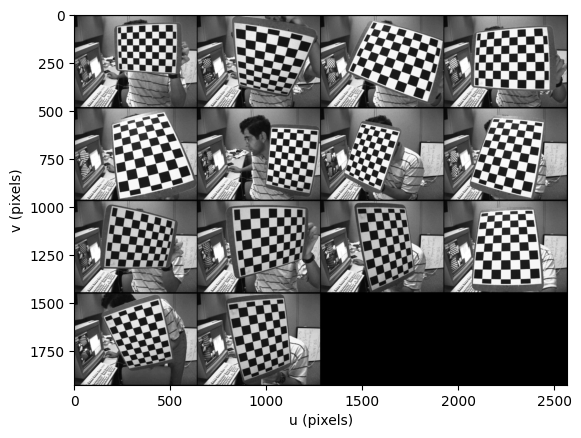

In [43]:
images = ImageCollection("calibration/*.jpg");
Image.Tile(images).disp()
len(images)

OpenCV provides a function to automatically find the chequerboards.  Given the size of each square, 25mm in this case, we can estimate the camera intrinsic parameters and the lens distortion model parameters

In [ ]:
K, distortion, frames = CentralCamera.images2C(images, gridshape=(7,6), squaresize=25e-3)

The camera intrinsic matrix is

In [ ]:
K

The image centre is given by the top two numbers in the right-hand column

which we can compare to the coordinates of the centre pixel of the image

In [ ]:
print(images[0].centre)

They are somewhat different, and that tells us that the optical axis of the camera does not pass through the middle pixel of the image.  That's never a good assumption.

We can also plot the estimated pose of the camera, relative to the chequerboard, for each image in the input sequence.

In [ ]:
for frame in frames:
  CentralCamera.plot(pose=frame.pose, scale=0.05)

ax = plt.gca()
ax.set_xlim(-0.2, 0.4)
ax.set_ylim(-0.2, 0.4)
ax.set_zlim(-0.6, 0)

Now let's look at the estimated distortion data.  The first three numbers are the coefficients of the radial distortion polynomial, while the last two numbers are the coefficients of the tangential distortion polynomial.

In [ ]:
distortion

We will unpack the camera parameters and distortion coefficients into scalar variables to make the following code easier to follow

In [ ]:
u0 = K[0, 2]; v0 = K[1, 2]; fpix_u = K[0, 0]; fpix_v = K[1,1];
k1, k2, p1, p2, k3 = distortion;

We choose to make the resulting undistorted image the same size as the input images.

In [ ]:
U, V = images[12].meshgrid()

the matrices `U` and `V` are coordinate matrices.  They have the same dimensions as the image used to create them, and for any pixel coordinate `(u,v)` the coordinate matrices are such that `U[v,u]=u` and `V[v,u]=v`

In [ ]:
print(U[100,200], V[100,200])

we convert the image coordinates to retinal image-plane coordinates, in units of metres with respect to the camera's principal point

In [ ]:
u = (U - u0) / fpix_u;
v = (V - v0) / fpix_v;

The radial distance of the pixels from the principal point is simply the Euclidean distance

In [ ]:
r = np.sqrt(u**2 + v**2);

and the restinal coordinate errors due to distortion are given by (13.15) in Robotics, Vision & Control: Python

In [ ]:
delta_u = u * (k1*r**2 + k2*r**4 + k3*r**6) + p1*u*v + p2*(r**2 + 2*u**2);
delta_v = v * (k1*r**2 + k2*r**4 + k3*r**6) + p1*(r**2 + 2*v**2) + p2*u*v;

So the undistorted coordinates are

In [ ]:
ud = u + delta_u; vd = v + delta_v;

and we convert those back to image plane coordinates

In [ ]:
Ud = ud * fpix_u + u0;
Vd = vd * fpix_v + v0;

Now `Ud[v,u]` and `Vd[v,u]` are the distorted coordinates of the point `(u,v)` and we can use this to warp the image to correct the distortion

In [ ]:
undistorted = images[12].warp(Ud, Vd)

Image.Hstack((images[12], undistorted)).disp()

In the side-by-side comparison we can see that the edges of, and lines on, the chequerboard have become straighter.

Another way to visually represent the image distortion is to show how $(\delta_u, \delta_v)$ changes as a function of $(u,v)$

In [ ]:
plt.clf()   # clear 3D plot
plt.quiver(Ud[::50, ::50], Vd[::50, ::50], -delta_u[::50, ::50], -delta_v[::50, ::50]);

which shows a pattern consistent with barrel distortion